In [53]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.control.hybrid_benchmark.utils import get_constraint_set, remove_redundant_inequalities_fast, convex_hull_method_fast

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
m = 1.
k = 100.
c = 4.
g = 10.
h = .02

In [3]:
# discretization method
method = 'zero_order_hold'

# dynamics n.1 (ball in the air)
A1 = np.array([
    [0., 0., 1.],
    [0., 0., 0.],
    [0., 0., 0.]
    ])
B1 = np.array([
    [0.],
    [1.],
    [0.]
    ])
c1 = np.array([
    [0.],
    [0.],
    [-g]
    ])
S1 = AffineSystem.from_continuous(A1, B1, c1, h, method)

# dynamics n.2 (paddle pulling ball)
S2 = copy(S1)

# dynamics n.1 (paddle pushing ball)
# (no offset terms, the zero of the position of the ball is shifted by m*g/k)
A3 = np.array([
    [0., 0., 1.],
    [0., 0., 0.],
    [-k/m, k/m, -c/m]
    ])
B3 = np.array([
    [0.],
    [1.],
    [c/m]
    ])
S3 = LinearSystem.from_continuous(A3, B3, h, method)

# list of dynamics
S_list = [S1, S2, S3]

In [4]:
# state bounds
x_max = np.array([
    [1.],
    [.1],
    [4.]
])
x_min = np.array([
    [-.3],
    [-.1],
    [-4.]
])
f_max = 4.*m*g


# input bounds
u_max = np.array([[.3]])
u_min = - u_max

# domain bounds
xu_min = np.vstack((x_min, u_min))
xu_max = np.vstack((x_max, u_max))

# domain n.1
# (out of contact when q_ball - q_paddle > m*g/k)
D1 = Polyhedron.from_bounds(xu_min, xu_max)
D1.add_inequality(
    np.array([[-1., 1., 0., 0.]]),
    np.array([[-m*g/k]])
)
assert D1.bounded
assert not D1.empty

# domain n.2
# (pulling when q_ball - q_paddle < m*g/k
# and f = k (qp - qb) + c (qpd - qbd) + m g < 0)
D2 = Polyhedron.from_bounds(xu_min, xu_max)
D2.add_inequality(
    np.array([[1., -1., 0., 0.]]),
    np.array([[m*g/k]])
)
D2.add_inequality(
    np.array([[-k, k, -c, c]]),
    np.array([[-m*g]])
)
assert D2.bounded
assert not D2.empty

# domain n.3
D3 = Polyhedron.from_bounds(xu_min, xu_max)
D3.add_inequality( # penetration > 0
    np.array([[1., -1., 0., 0.]]),
    np.array([[m*g/k]])
)
D3.add_inequality( # not pulling
    np.array([[k, -k, c, -c]]),
    np.array([[m*g]])
)
D3.add_inequality( # maximum force < 5 m g
    np.array([[-k, k, -c, c]]),
    np.array([[f_max - m*g]])
)
assert D3.bounded
assert not D3.empty

# list of domains
D_list = [D1, D2, D3]

In [5]:
S = PieceWiseAffineSystem(S_list, D_list)

In [6]:
# controller parameters
N = 75
Q = np.diag([0.,0.,1.])*h
R = np.diag([10.])*h

# terminal set and cost
P = Q
X_N = Polyhedron.from_bounds(np.zeros((3,1)),np.zeros((3,1)))
# P, K = S3.solve_dare(Q, R)
# X_N = S3.mcais(K, D3, verbose=True)
# X_N = Polyhedron.from_bounds(x_min, x_max)
# X_N.add_lower_bound(np.array([[1.]]),[0])
# P = Q

controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'Multiple big-Ms')

x0 = np.array([[1.], [.0], [.0]])
u_mip, x_mip, ms_mip, cost_mip = controller.feedforward(x0)

In [78]:
x0 = np.array([[1.], [.0], [.0]])
methods = [
    'MLD equivalent',
#     'Traditional big-M',
    'Big-M',
    'Convex hull',
    'Convex hull lifted constraints'
]
solves = {}
for method in methods:
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    controller.prog.setParam('OutputFlag', 0)
#     controller.prog.setParam('Heuristics', 1)
#     controller.prog.setParam('MIPFocus', 0)
    u_mip, x_mip, ms_mip, cost_mip = controller.feedforward(x0)
    print controller.prog.objVal
    solves[method] = {
        'time': controller.prog.Runtime,
        'nodes': controller.prog.NodeCount
    }

In [8]:
for method in methods:
    print method
    print 'Solution time:', solves[method]['time']
    print 'Explored nodes:', solves[method]['nodes']

Bemporad Morari 1999
Solution time: 138.599963903
Explored nodes: 120864.0
Multiple big-Ms
Solution time: 7.07639908791
Explored nodes: 11808.0
Convex hull
Solution time: 8.64633607864
Explored nodes: 5958.0
Convex hull lifted constraints
Solution time: 11.8456060886
Explored nodes: 2479.0


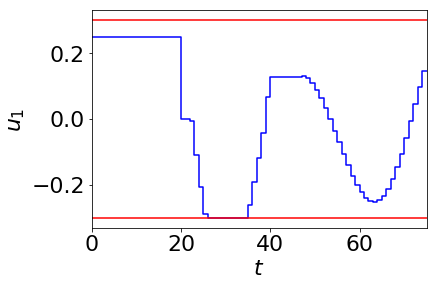

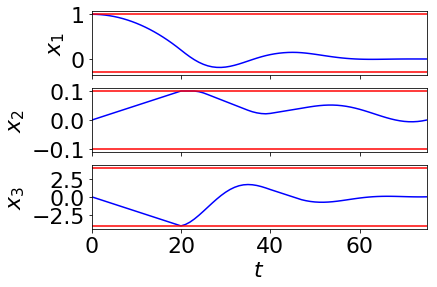

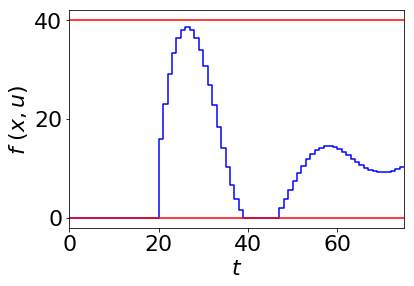

In [75]:
plt.rc('font', size=22)

# input
plot_input_sequence(u_mip, h, (u_min, u_max), legend=False)
plt.savefig('input.pdf',bbox_inches='tight')
plt.show()

# state
plot_state_trajectory(x_mip, h, (x_min, x_max), legend=False)
plt.savefig('state.pdf',bbox_inches='tight')
plt.show()

# output (contcat force)
f = [k*(x_mip[t][1]-x_mip[t][0]) + c*(u_mip[t][0]-x_mip[t][2]) + m*g for t in range(N)]
for t in range(N):
    if ms_mip[t] != 2:
        f[t] = 0.
f = [f[0]] + f
plt.step(range(N+1), f, color='b')
plt.step(range(N+1), [f_max]*(N+1), color='r')
plt.step(range(N+1), [0.]*(N+1), color='r')
plt.xlabel(r'$t$')
plt.ylabel(r'$f \ (x,u)$')
plt.xlim((0., N))
plt.savefig('force.pdf',bbox_inches='tight')
plt.show()

In [85]:
costs = {}
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    costs[method] = []
    for ms in [ms_mip[:i] for i in range(N+1)]:
        cost = controller.feedforward_relaxation(x0, ms)[3]
        if cost is not None:
            cost /= cost_mip
        costs[method].append(cost)

MLD equivalent
Big-M
Convex hull
Convex hull lifted constraints


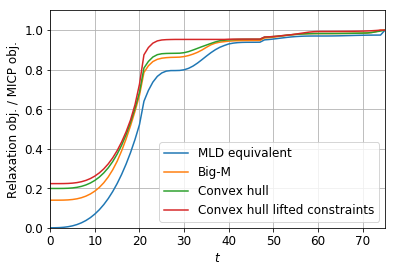

In [97]:
plt.rc('font', size=12)
for method in methods:
    plt.plot(range(N+1), costs[method], label=method)
plt.xlim((0, N))
plt.ylim((0, 1.1))
plt.legend()
plt.grid()
plt.xlabel(r'$t$')
plt.ylabel(r'Relaxation obj. / MICP obj.')
plt.savefig('relaxation_ratio.pdf',bbox_inches='tight')

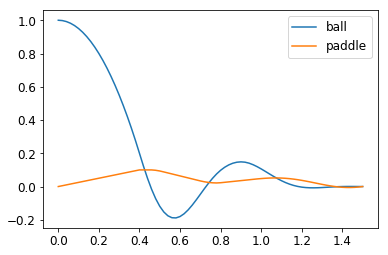

In [96]:
plt.plot(h*np.array(range(N+1)),[xt[0] for xt in x_mip], label='ball')
plt.plot(h*np.array(range(N+1)),[xt[1] for xt in x_mip], label='paddle')
plt.legend()

In [ ]:
q_p = 0.
n_samples = 11
q_b_samples = np.linspace(x_min[0], x_max[0], n_samples)
v_b_samples = np.linspace(x_min[2], x_max[2], n_samples)
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    cs = get_constraint_set(controller.prog)
    var_indices = {v: i for i, v in enumerate(controller.prog.getVars())}
    v_index = var_indices[controller.prog.getVarByName('x0[1]')]
    A_sect = np.hstack((cs.A[:, :v_index], cs.A[:, v_index+1:]))
    b_sect = cs.b - cs.A[:, v_index:v_index+1] * q_p
    cs_sect = Polyhedron(A_sect, b_sect)
    sect = convex_hull_method_fast(cs_sect, [0,1])
    cost_mat = np.empty([n_samples]*2)
    for i, q_b in enumerate(q_b_samples):
        for j, v_b in enumerate(v_b_samples):
            print(str(i) + ',' + str(j) + '\r'),
            x0 = np.array([[q_b],[q_p],[v_b]])
            cost = controller.feedforward_relaxation(x0, [])[3]
            cost_mat[i,j] = cost
    Q_b, V_b = np.meshgrid(q_b_samples, v_b_samples)
    cp = plt.contour(Q_b, V_b, cost_mat.T)
    plt.colorbar(cp, label='Relaxation objective')
    sect.plot(facecolor='w', label='Feasible set section')
    plt.xlabel(r'$x_1$')
    plt.xlabel(r'$x_3$')
    plt.legend()
    plt.savefig(method + '.pdf')

MLD equivalent


In [ ]:
# constraint set of the relaxation
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'big_m')
# controller.reset_program()
cs = get_constraint_set(controller.prog)

In [ ]:
# section of the constraint set
q_p = 0.
var_indices = {v: i for i, v in enumerate(controller.prog.getVars())}
v_index = var_indices[controller.prog.getVarByName('x0[1]')]
A_sect = np.hstack((cs.A[:, :v_index], cs.A[:, v_index+1:]))
b_sect = cs.b - cs.A[:, v_index:v_index+1] * q_p
cs_sect = Polyhedron(A_sect, b_sect)
# cs_sect = remove_redundant_inequalities_fast(cs_sect)
# res_dim = [var_indices[controller.prog.getVarByName(v)] for v in ['x0[0]','x0[2]']]
sect = convex_hull_method_fast(cs_sect, [0,1])

In [ ]:
n_samples = 51
q_b_samples = np.linspace(x_min[0], x_max[0], n_samples)
v_b_samples = np.linspace(x_min[2], x_max[2], n_samples)
cost_mat = np.empty([n_samples]*2)
for i, q_b in enumerate(q_b_samples):
    for j, v_b in enumerate(v_b_samples):
        print(str(i) + ',' + str(j) + '\r'),
        x0 = np.array([[q_b],[q_p],[v_b]])
        cost = controller.feedforward_relaxation(x0, [])[3]
        cost_mat[i,j] = cost

In [ ]:
Q_b, V_b = np.meshgrid(q_b_samples, v_b_samples)
cp = plt.contour(Q_b, V_b, cost_mat.T)
plt.colorbar(cp, label='Relaxation cost')
sect.plot(facecolor='w', label='Feasible set slice')
plt.legend()
# plt.savefig('convex_hull.pdf')

Q, Qd = np.meshgrid(q_samples, qd_samples)
cp = plt.contourf(Q, Qd, cost_mat.T)
plt.colorbar(cp, label='Real cost')
plt.savefig('real_cost.pdf')

In [ ]:
cost_mat = np.empty([n_samples]*2)
for i, q_b in enumerate(q_b_samples):
    for j, v_b in enumerate(v_b_samples):
        print(str(i) + ',' + str(j) + '\r'),
        x0 = np.array([[q_b],[q_p],[v_b]])
        cost = controller.feedforward(x0)[3]
        cost_mat[i,j] = cost
Q_b, V_b = np.meshgrid(q_b_samples, v_b_samples)
cp = plt.contour(Q_b, V_b, cost_mat.T)
plt.colorbar(cp, label='MIP cost')
sect.plot(facecolor='w', label='Feasible set slice')
plt.legend()